# Imports

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

import umap

from scipy import stats

from src.visualization import (
    plot_kde,
    plot_animated_scatter_notebook_only,
    plot_specific_feature,
    plot_zeros,
    plot_feature_spans,
    plot_correlation_coefficients,
    plot_correlated_pairplot,
    plot_feature_selection_metrics
)

from sklearn.feature_selection import (
    mutual_info_regression,
    VarianceThreshold,
    mutual_info_regression
)

import mrmr

# Paths

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
print(DATA_DIR)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/data


# Data Cleaning

In [4]:
dev_file_name = "assignment1_dev_set.csv"
val_file_name = "assignment1_val_set.csv"

dev_df = pd.read_csv(os.path.join(DATA_DIR, dev_file_name), index_col=0)
val_df = pd.read_csv(os.path.join(DATA_DIR, val_file_name), index_col=0)

display(dev_df.columns)
display(val_df.columns)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

In [5]:
cols_to_drop = [
    "Project ID",
    "Experiment type",
    "Disease MESH ID"
]

dev_df = dev_df.drop(columns=cols_to_drop)
val_df = val_df.drop(columns=cols_to_drop)

In [6]:
display(np.where(dev_df.isnull().sum() > 0))
display(np.where(val_df.isnull().sum() > 0))

(array([], dtype=int64),)

(array([], dtype=int64),)

The meta columns have been removed. There are no null values. I will save these DataFrames as the final DataFrames.

In [7]:
dev_df.to_csv(os.path.join(DATA_DIR, "development_final.csv"))
val_df.to_csv(os.path.join(DATA_DIR, "validation_final.csv"))

# The data

I will merge the valuation and the devolepment sets to get a bigger data set for my preliminary analyses.

In [8]:
dev_file_name = "development_final.csv"

df = pd.read_csv(os.path.join(DATA_DIR, dev_file_name), index_col=0)

cols = df.columns

Regarding the `Sex` and `Host age` columns, I decided to separate them in order to examine them one by one, and not with the bacterial data.

In [9]:
# drop columns Project ID, Experiment type, Sex, Host age, Disease MESH ID
cols_to_drop = [
    "Sex",
    "Host age",
    "BMI"
]

bmi = df["BMI"]
sex = df["Sex"]
age = df["Host age"]
bacteria = df.drop(cols_to_drop, axis=1)

In [10]:
bacteria.head()

Acholeplasma axanthum  Acidaminococcus fermentans  \
0               0.000000                    0.000000   
1               0.001028                    0.000000   
2               0.001406                    0.000000   
3               0.000000                    0.008825   
4               0.002878                    0.037419   

   Acidaminococcus intestini  Actinomyces lingnae  Akkermansia muciniphila  \
0                   0.000000             0.000000                 0.017674   
1                   0.000000             0.000000                13.015800   
2                   0.000000             0.001406                 0.002812   
3                   0.273562             0.000000                 0.044123   
4                   7.359970             0.000000                 0.872143   

   Alistipes finegoldii  Alistipes indistinctus  Alistipes obesi  \
0              0.000000                 0.00000              0.0   
1              0.001542                 0.00000              0.0   
2              0.201074                 0.00000              0.0   
3              0.004412                 0.34857              0.0   
4              0.000000                 0.00000              0.0   

   Alistipes onderdonkii  Alistipes putredinis  ...  Clostridium sphenoides  \
0               0.117827              0.005891  ...                0.005891   
1               0.073486              0.403916  ...                0.000000   
2               0.043590              0.105459  ...                0.000000   
3               0.026474              0.586834  ...                0.017649   
4               1.732770              1.004550  ...                0.305106   

   Clostridium spiroforme  Clostridium stercorarium  Clostridium symbiosum  \
0                0.029457                  0.000000               0.000000   
1                0.002569                  0.412652               0.003083   
2                0.005624                  0.002812               0.007031   
3                0.198553                  0.000000               0.158842   
4                0.135283                  0.000000               0.051811   

   Clostridium thermosuccinogenes  Clostridium xylanolyticum  \
0                        0.002946                   0.000000   
1                        0.000000                   0.000000   
2                        0.000000                   0.000000   
3                        0.030886                   0.101483   
4                        0.054689                   0.083473   

   Eubacterium brachy  Eubacterium dolichum  Eubacterium sulci  \
0            0.000000              0.000000           0.002946   
1            0.008736              0.014903           0.077597   
2            0.000000              0.000000           0.005624   
3            0.000000              0.000000           0.000000   
4            0.020148              0.000000           0.054689   

   Ruminococcus gnavus  
0             0.100153  
1             0.004625  
2             0.016873  
3             0.000000  
4             0.011513  

[5 rows x 134 columns]

## General Overview

### BMI

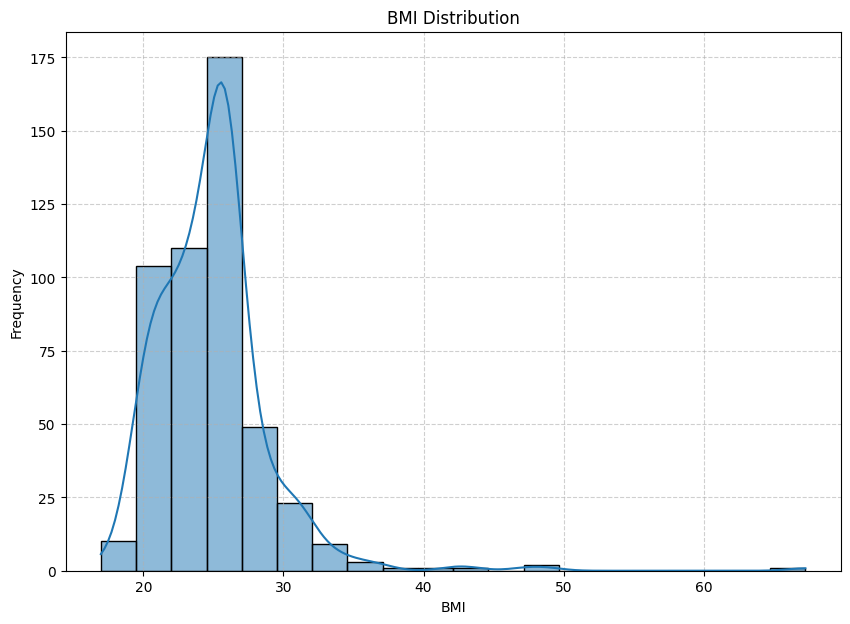

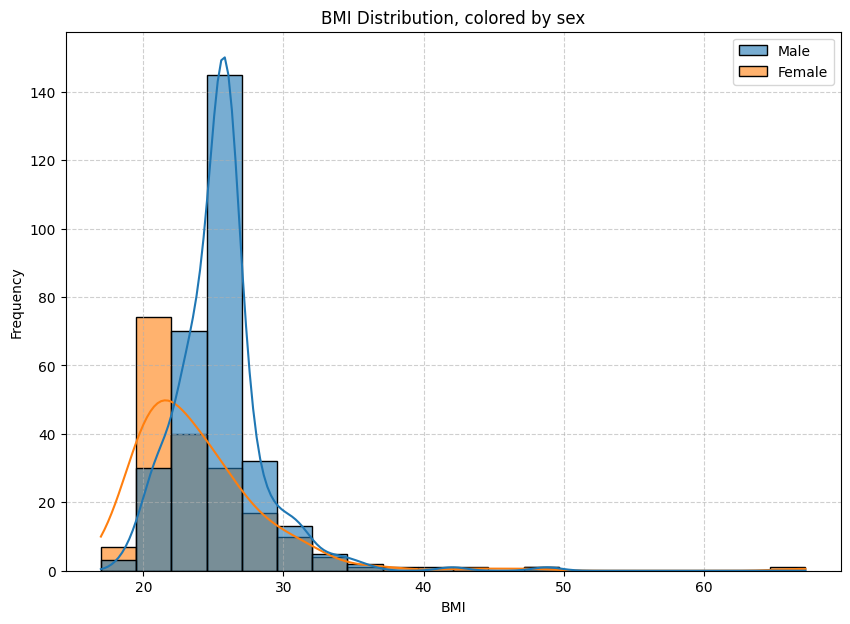

In [11]:
plot_kde(
    bmi,
    title="BMI Distribution",
    x_label="BMI"
)
plot_kde(
    bmi,
    title="BMI Distribution, colored by sex",
    x_label="BMI",
    hue_by=sex
)

In [12]:
# Perform the Lillefors (Kolmogorov-Smirnov) test for normality on BMI
alpha = 0.05
stat, p = stats.normaltest(bmi)
print(f"stat: {stat}, p: {p}")
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected, the data is normally distributed")

stat: 396.2275107282368, p: 9.126184747321433e-87
The null hypothesis can be rejected


### Bacteria

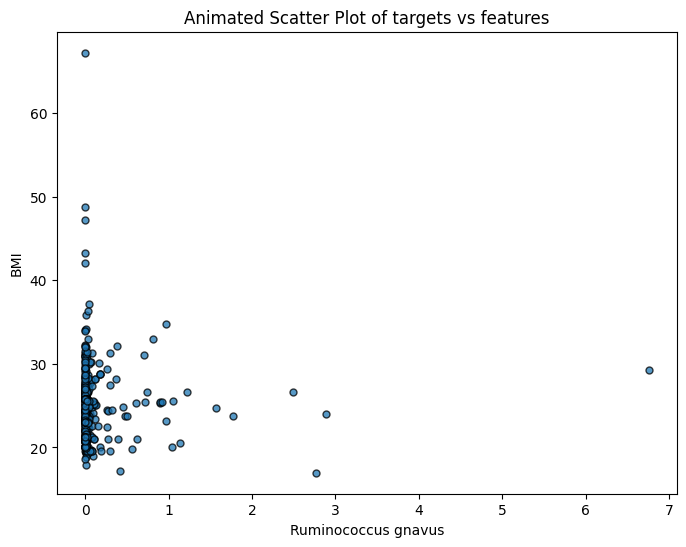

In [13]:
# Animated plot, please rerun this cell to see the animation if you missed it,
# it might take some time though to show all bacteria, adjust the time step <t> if
# needed

plot_animated_scatter_notebook_only(bmi, bacteria, t=0.1)

In [14]:
plot_zeros(bacteria, bmi)

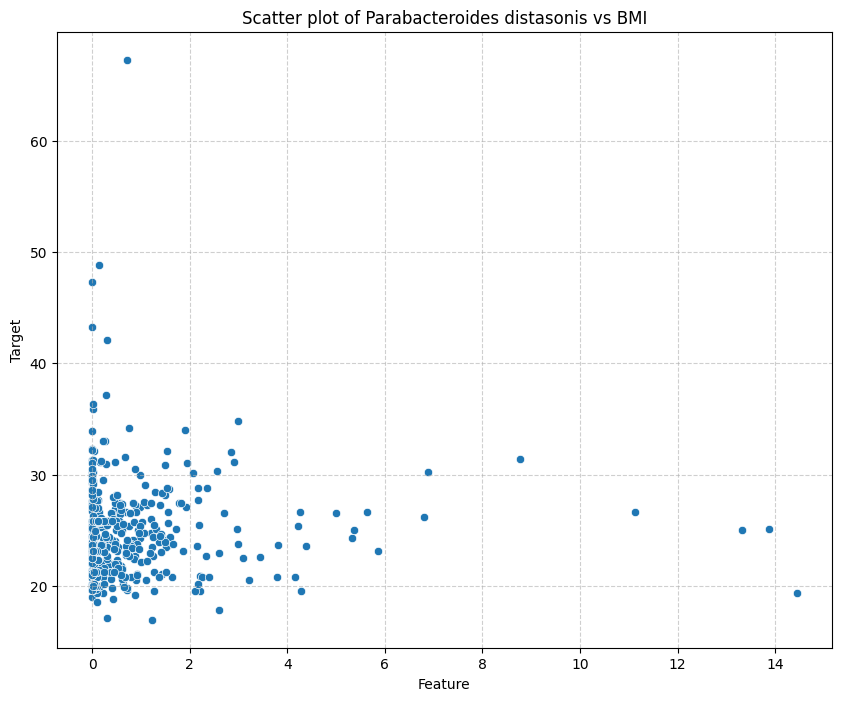

In [15]:
# Inspect specific bacteria here:

plot_specific_feature(bacteria, "Parabacteroides distasonis", bmi)

In [16]:
plot_feature_spans(bacteria)

Lets normalize them and see what they look like.

In [17]:
def zscore(col):
    return (col - col.mean()) / col.std()


def minmax(col):
    return (col - col.min()) / (col.max() - col.min())

In [18]:
bacteria_zscaled = bacteria.apply(zscore, axis=0)
bacteria_mmscaled = bacteria.apply(minmax, axis=0)

In [19]:
plot_feature_spans(
    bacteria_zscaled, title="Standardized Features", sort_features_by="max"
)
plot_feature_spans(
    bacteria_mmscaled, title="MinMaxed Features"
)

### Sex and Age

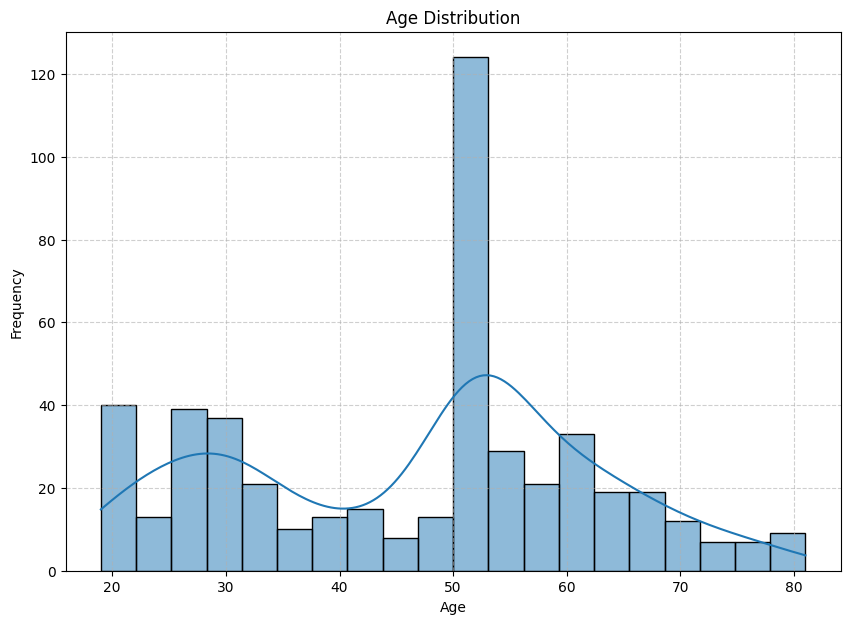

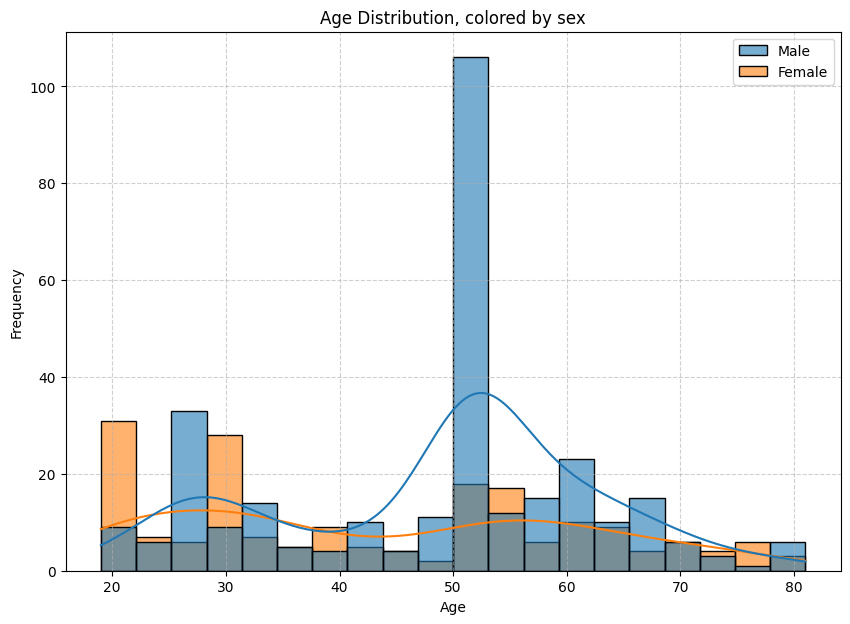

In [20]:
plot_kde(
    age,
    title="Age Distribution",
    x_label="Age"
)
plot_kde(
    age,
    title="Age Distribution, colored by sex",
    x_label="Age",
    hue_by=sex
)

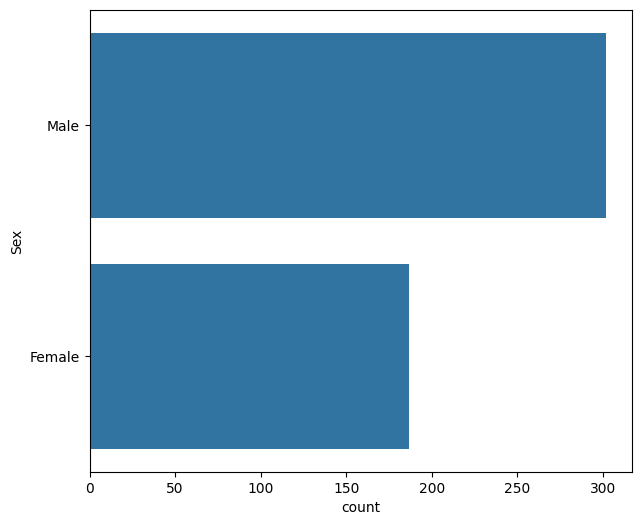

In [21]:
plt.figure(figsize=(7, 6))
sns.countplot(sex)
plt.show()

In [22]:
plot_correlation_coefficients(age, bmi)

(array([[0.27286165, 0.28146068, 0.19435634]]), ['Host age'])

In [23]:
plot_correlation_coefficients(sex.replace({"Male": 1, "Female": -1}), bmi)

(array([[0.16577686, 0.30479338, 0.25357346]]), ['Sex'])

## Correlations

In [24]:
bacteria_corr_array_bmi, bacteria_sorted_by_corr_bmi = plot_correlation_coefficients(
    bacteria,
    bmi,
    abs_corr=True,
    title="Correlation Coefficients (absolute values) of Bacteria against BMI"
)

In [25]:
bacteria_corr_array_age, bacteria_sorted_by_corr_age = plot_correlation_coefficients(
    bacteria,
    age,
    abs_corr=True,
    title="Correlation Coefficients (absolute values) of Bacteria against age"
)

#### Correlation between features

Let's inspect the feature correlation of the top `n` most correlated bacteria with bmi.

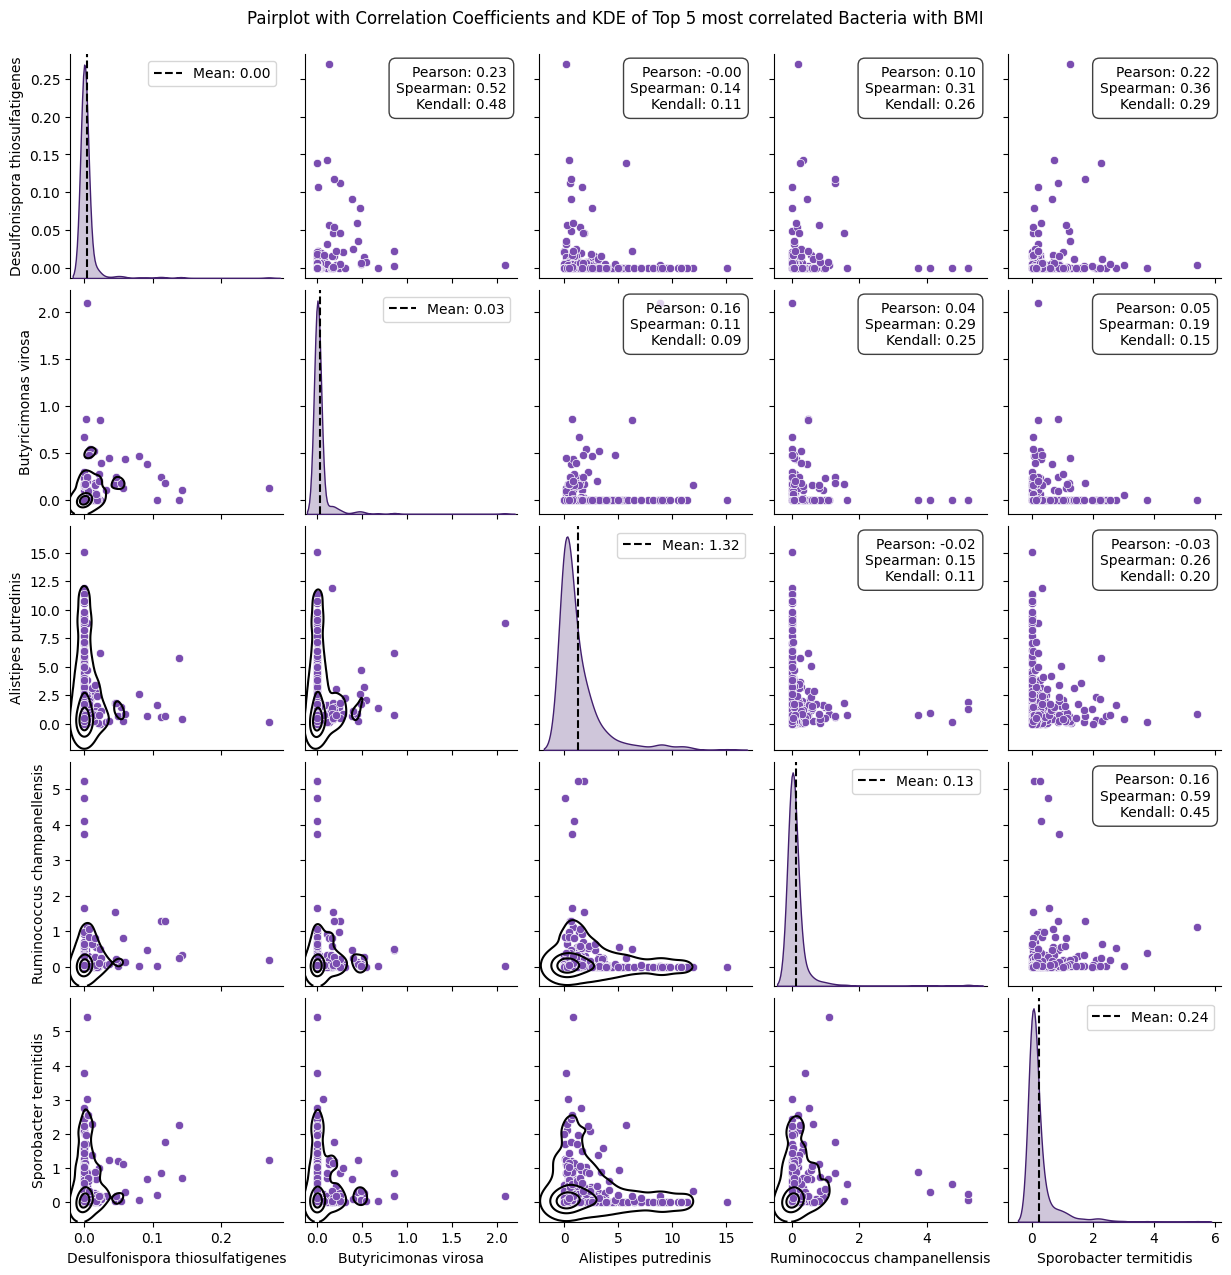

In [26]:
n = 5
first_n_bacteria_names = bacteria_sorted_by_corr_bmi[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with BMI"
)

Same as above but for bacteria and age.

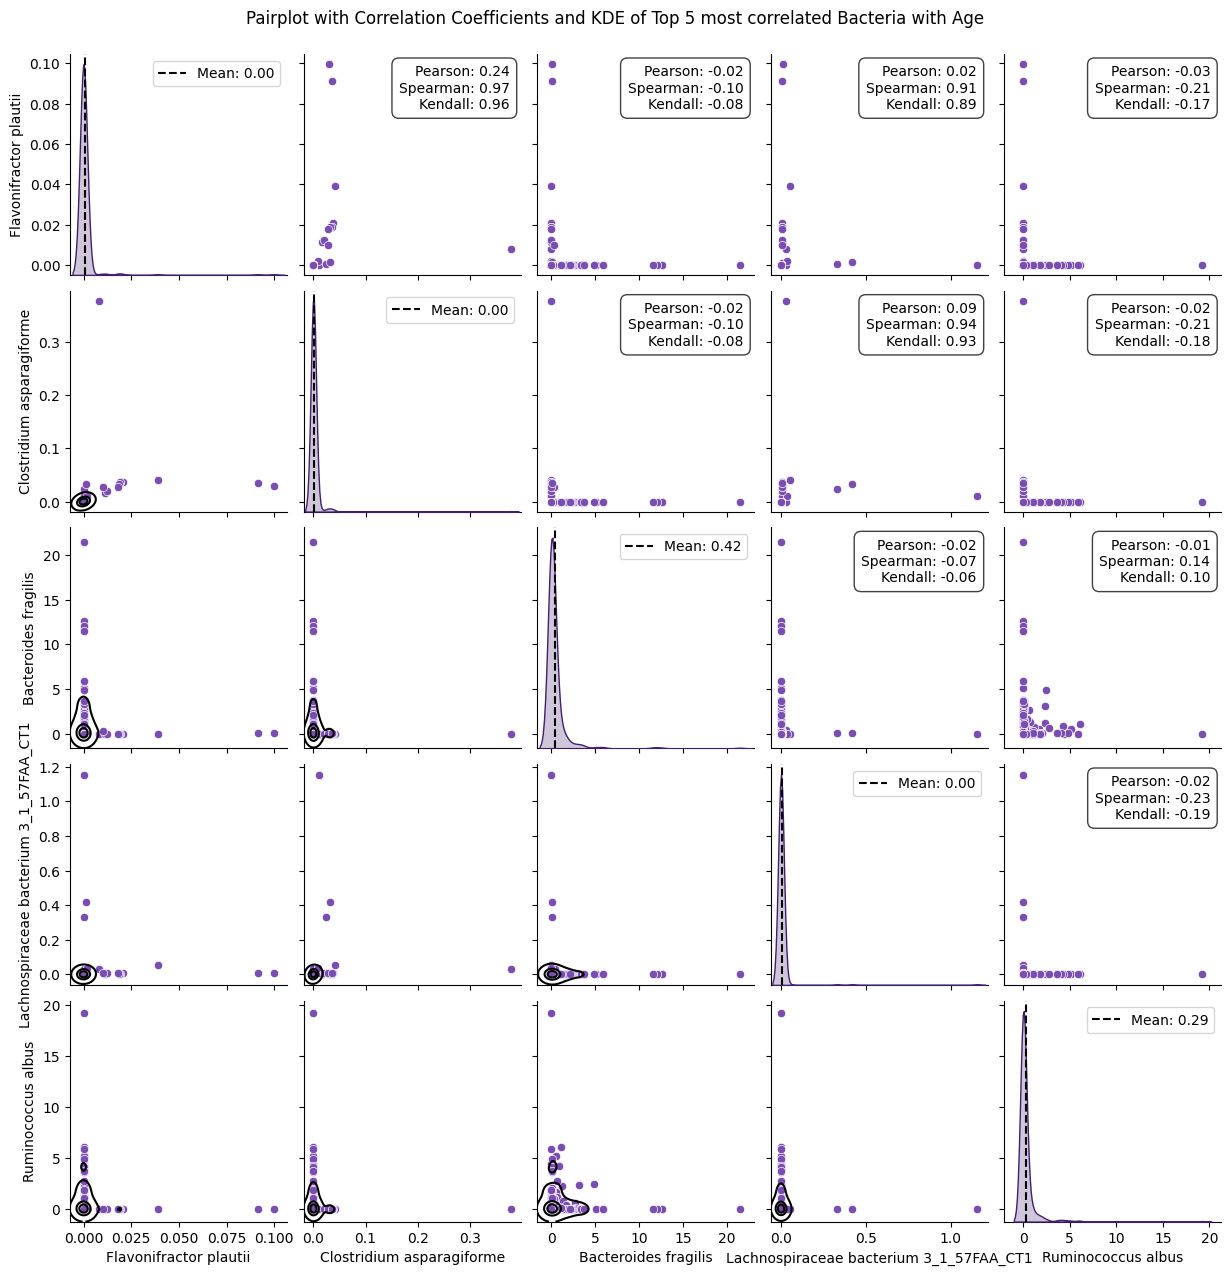

In [27]:
n = 5
first_n_bacteria_names = bacteria_sorted_by_corr_age[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with Age"
)

## Visualizations on reduced dimensions on the feature space

Now lets inspect the feature space in reduced dimensions and see if we can find anything that might help us later on.

Number of components that explain 65% of the variance: 5


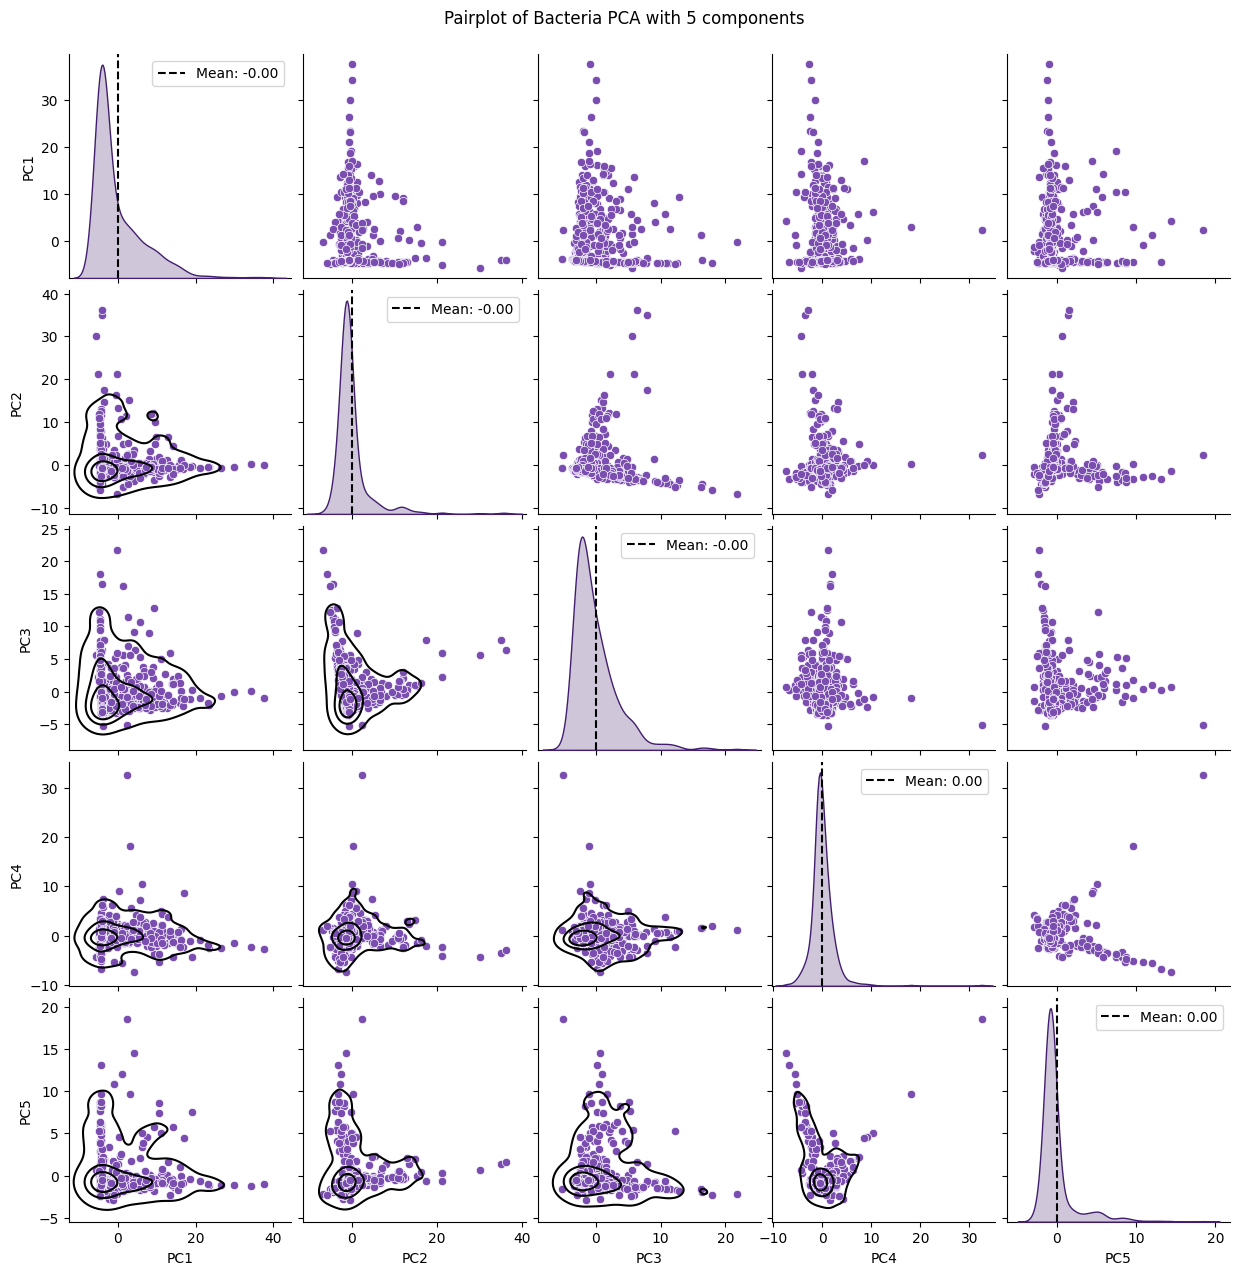

In [28]:
# PCA
pca = PCA()
bacteria_pca = pca.fit_transform(bacteria)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_explained_variance_ratio > 0.65) + 1
print(f"Number of components that explain 65% of the variance: {n_components}")

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_pca[:, :n_components],
        columns=[f"PC{i}" for i in range(1, n_components + 1)]
    ),
    title=f"Pairplot of Bacteria PCA with {n_components} components",
    overlay_correlations=False
)

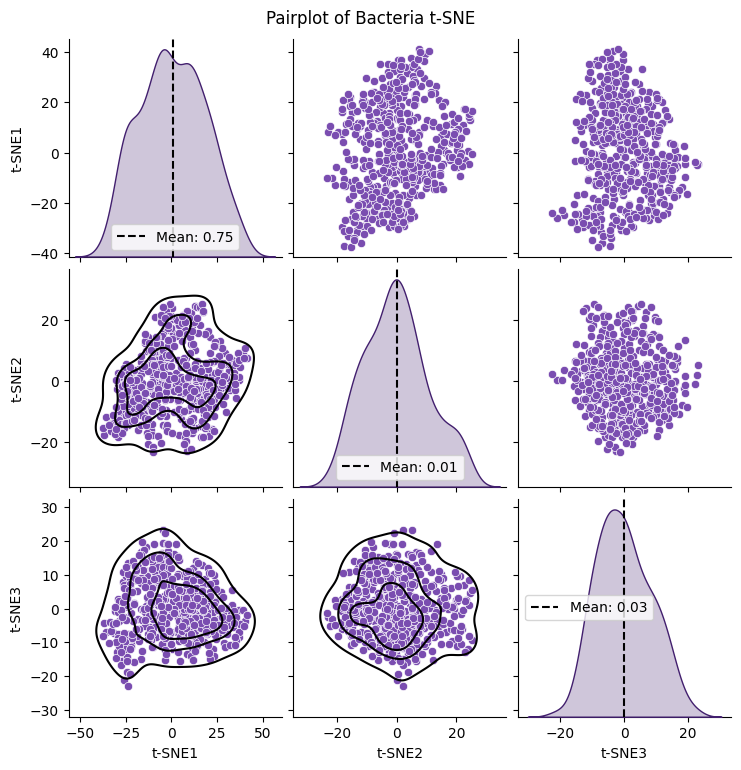

In [29]:
# t-SNE
tsne = TSNE(n_components=3)
bacteria_tsne = tsne.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_tsne,
        columns=[f"t-SNE{i}" for i in range(1, 4)]
    ),
    title="Pairplot of Bacteria t-SNE",
    overlay_correlations=False
)

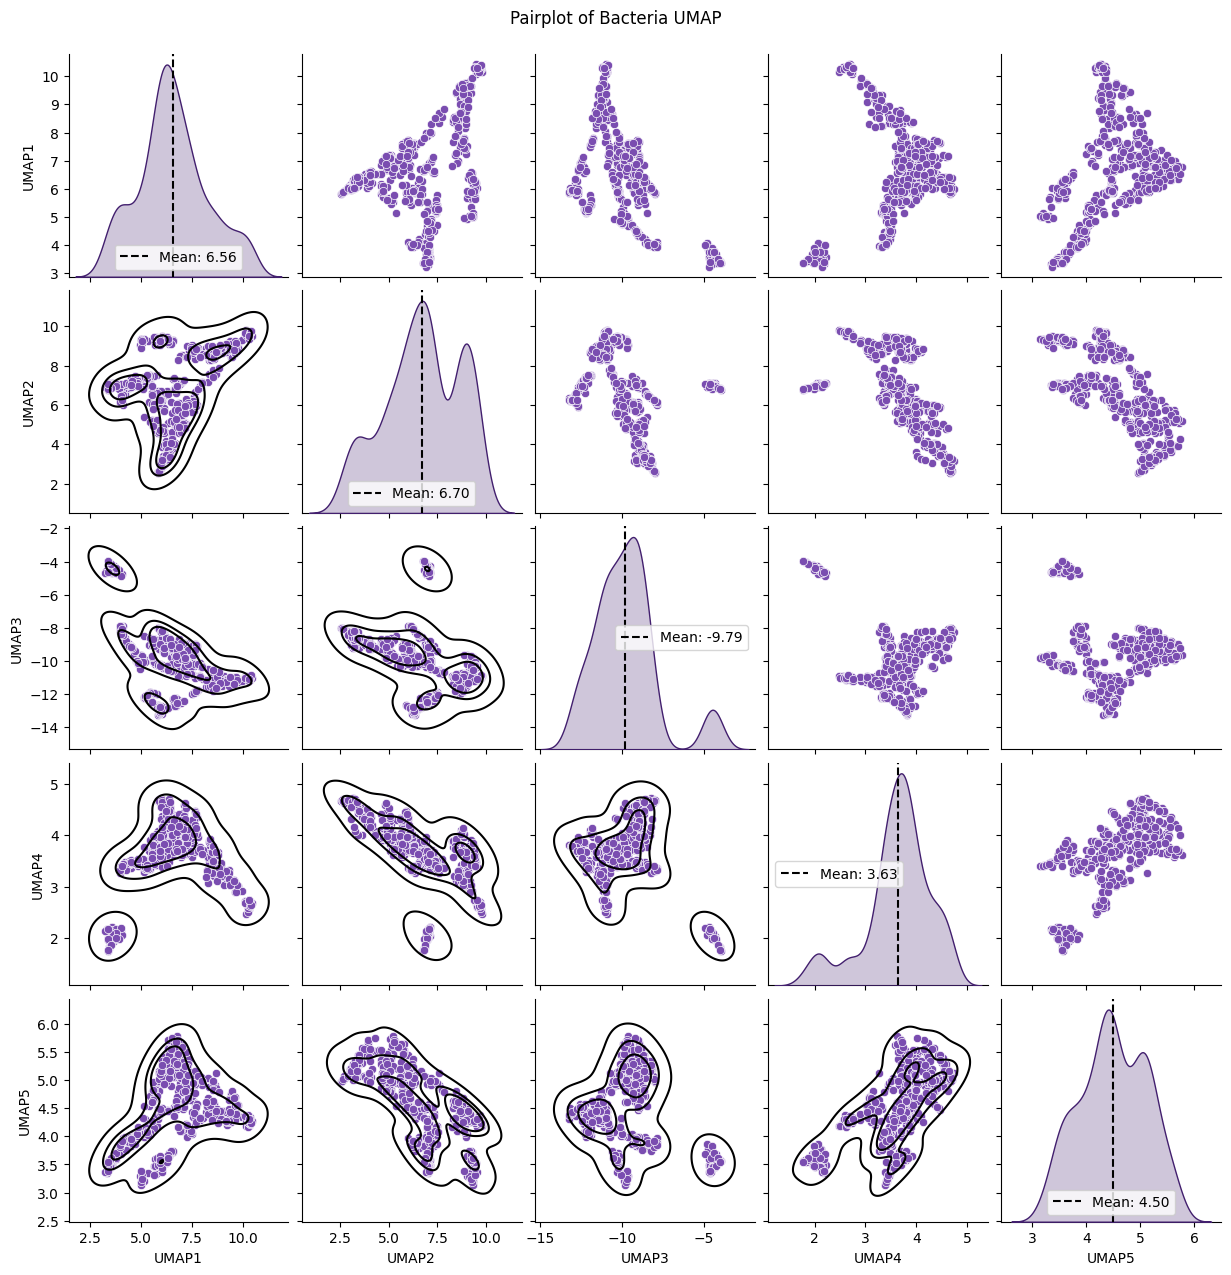

In [30]:
# UMAP
umap_model = umap.UMAP(n_components=5)
bacteria_umap = umap_model.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Bacteria UMAP",
    overlay_correlations=False
)

# Conclusion

- First we can observe that the`BMI` (dependent variable) does not follow the normal distribution, so a simple linear regression model like the least squares
will likely not work. One interesting thing to notice is that the male participants have a higher `BMI` than the female participants, which will likely play a
role in the final model.
- When observing the animated scatter plot we can see that there are not distinct bacterial species correlate with the `BMI` and also we can see that an
overwhelming majority of the `bacteria` have a value of zero.
- When plotting the number of bacteria with zero values and the mean `BMI` when the bacteria are not zero we get something interesting. The bacteria with many
zero values, show a higher `BMI` compared to the rest, when they exist.
- The features (`bacteria`) lie close to $0$ with only a few outliers as seen by their means and Inter Quantile Ranges (IQR). A MinMax normalization would make
the features very sparce in the range $[0, 1]$, so a Standardization seems like a better approach.
- Using **Pearson's r**, **Spearman's r**, and **Kendall's tau** correlation coefficients we see that there is not a single bacterial species that is highly
correlated (either positively or negatively) with `BMI`. Plotting a pairplot of the `n` most correlated features with `BMI` we can see that those features are
not highly correlated between them selves so at least they in theory carry different information and using them would be helpful.
- When using either of the three dimensionality reduction methods (**PCA**, **t-SNE**, **UMAP**) no visible clusters form, except for some slight clustering in
the case of **UMAP**.

# Feature Selection

I will check several methods for feature selection and I plan on examining them all here. The notebook that performs the regression task will use the features
selected with the best method as defined here.  
To check which method is optimal I will use UMAP to recude the dimensions of the feature space, plot them, and color each point with a gradient relating to the
BMI. I will also calculate their **mutual information (MI)**, their **Variance**, and the **Information Gain (IG)** using `sklearn.feature_selection`'s 
`mutual_info_regression`, `VarianceThreshold`, and `mutual_info_regression`.

In [31]:
feature_selection_metrics = pd.DataFrame(
    {
        "Method": [],
        "Number of Features": [],
        "Mutual Information": [],
        "Variance": [],
        "Information Gain": []
    }
)

In [32]:
scaler = StandardScaler()
bacteria_standardized = pd.DataFrame(scaler.fit_transform(bacteria), columns=bacteria.columns, index=bacteria.index)

### 1st method: Select features based on correlation coefficients

In [33]:
# Keep age and sex, keep the 25% most correlated bacteria

bacteria_to_keep = bacteria_sorted_by_corr_bmi[:int(len(bacteria_standardized.columns) * 0.25)]
bacteria_to_keep = bacteria[bacteria_to_keep]

selected_features_corr = pd.concat(
    [
        bacteria_to_keep,
        age,
        sex.replace({
        "Male": 1,
        "Female": -1
        })
    ],
    axis=1
)

In [34]:
selector = VarianceThreshold(threshold=0.1)
selector.fit(selected_features_corr)

new_row = pd.DataFrame({
    "Method": ["Correlation"],
    "Number of Features": [selected_features_corr.shape[1]],
    "Mutual Information": [mutual_info_regression(
        selected_features_corr,
        bmi
    ).mean()],
    "Variance": [selected_features_corr[
        selected_features_corr.columns[selector.get_support()]
    ].var().mean()],
    "Information Gain": [mutual_info_regression(
        selected_features_corr,
        bmi
    ).mean()]
})

feature_selection_metrics = pd.concat([
    feature_selection_metrics,
    new_row
], ignore_index=True)

feature_selection_metrics

Method  Number of Features  Mutual Information   Variance  \
0  Correlation                35.0            0.123062  15.156343   

   Information Gain  
0          0.121079

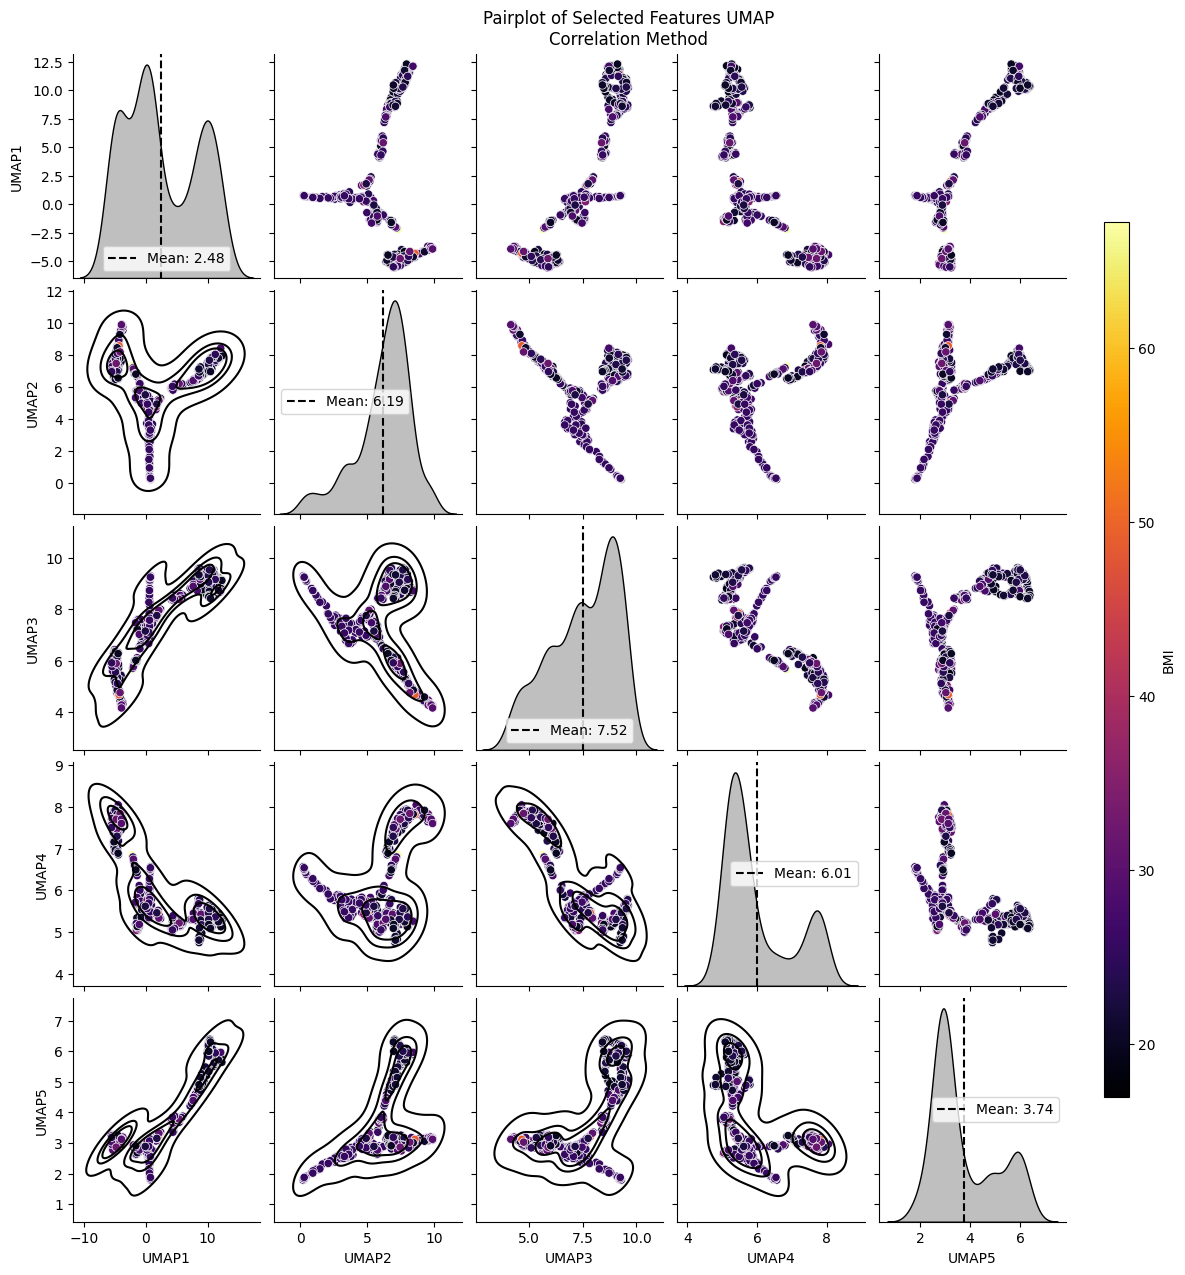

In [35]:
umap_model = umap.UMAP(n_components=5)
selected_features_umap = umap_model.fit_transform(selected_features_corr)

plot_correlated_pairplot(
    pd.DataFrame(
        selected_features_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Selected Features UMAP\nCorrelation Method",
    kde_color="black",
    hue=bmi,
    cmap="inferno",
    overlay_correlations=False
)

### 2nd method: Select features using Lasso regression

In [36]:
lasso = LassoCV(cv=5, alphas=np.logspace(-3, 1, 50), random_state=42)
lasso.fit(bacteria_standardized, bmi)

selected_features_lasso = bacteria[bacteria_standardized.columns[
    lasso.coef_ != 0
]]

selected_features_lasso = pd.concat(
    [
        selected_features_lasso,
        age,
        sex.replace({
        "Male": 1,
        "Female": -1
        })
    ],
    axis=1
)

In [37]:
selector = VarianceThreshold(threshold=0.1)
selector.fit(selected_features_lasso)

new_row = pd.DataFrame({
    "Method": ["Lasso"],
    "Number of Features": [selected_features_lasso.shape[1]],
    "Mutual Information": [mutual_info_regression(
        selected_features_lasso,
        bmi
    ).mean()],
    "Variance": [selected_features_lasso[
        selected_features_lasso.columns[selector.get_support()]
    ].var().mean()],
    "Information Gain": [mutual_info_regression(
        selected_features_lasso,
        bmi
    ).mean()]
})

feature_selection_metrics = pd.concat([
    feature_selection_metrics,
    new_row
], ignore_index=True)

feature_selection_metrics

Method  Number of Features  Mutual Information    Variance  \
0  Correlation                35.0            0.123062   15.156343   
1        Lasso                 2.0            0.484809  124.161939   

   Information Gain  
0          0.121079  
1          0.480316

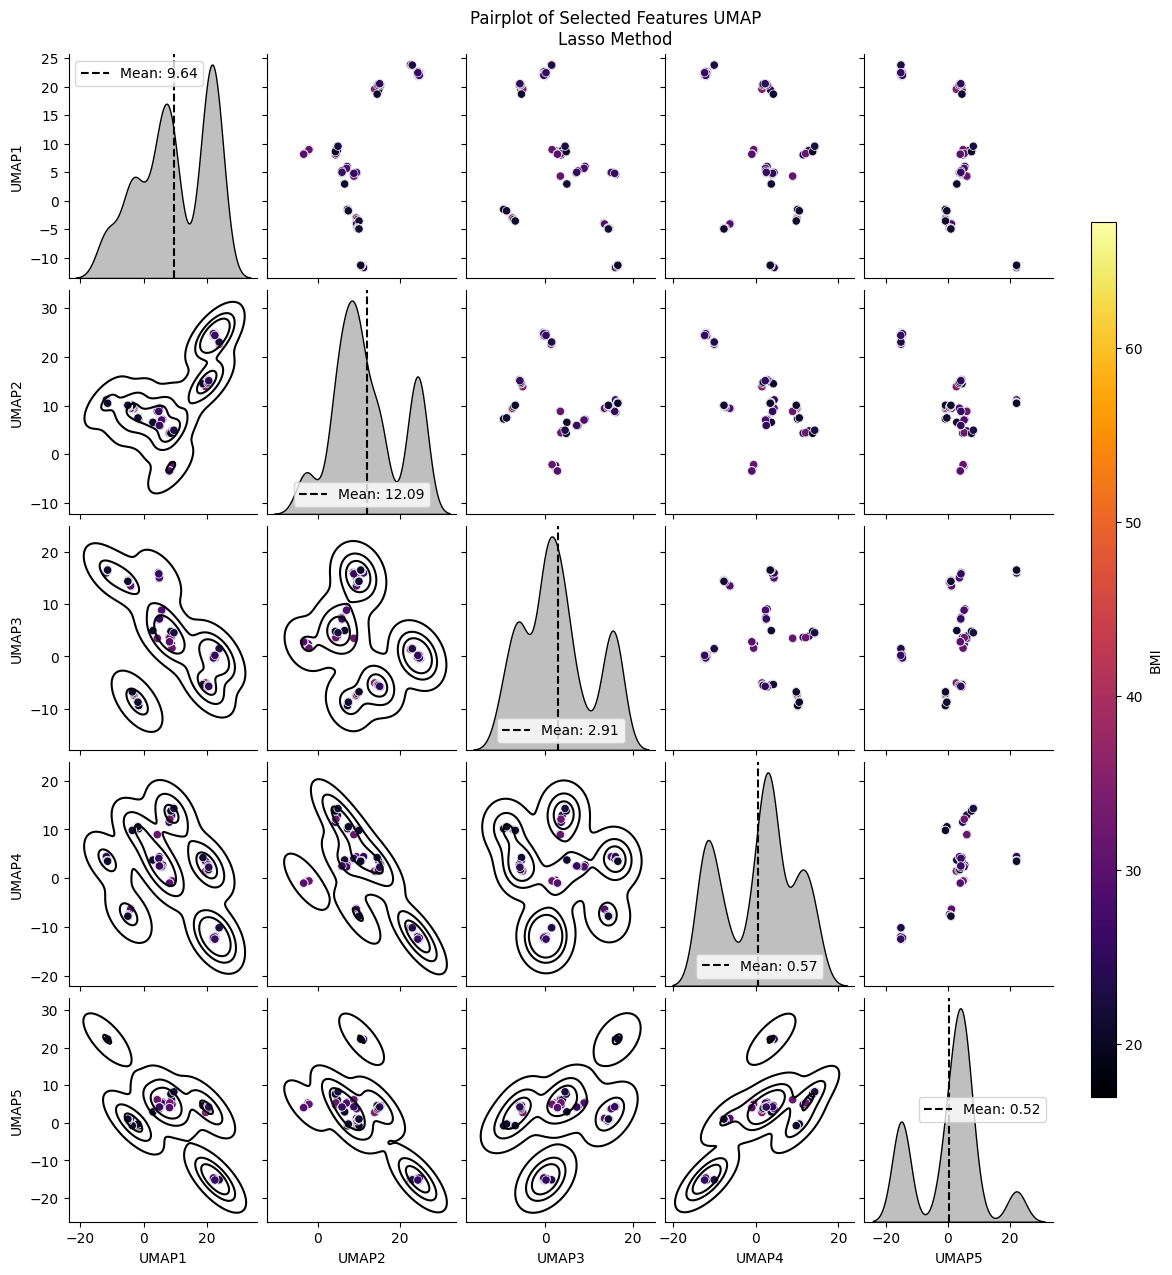

In [38]:
selected_features_umap = umap_model.fit_transform(selected_features_lasso)

plot_correlated_pairplot(
    pd.DataFrame(
        selected_features_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Selected Features UMAP\nLasso Method",
    kde_color="black",
    hue=bmi,
    cmap="inferno",
    overlay_correlations=False
)

### 3rd method: Select features using minimum Redundancy - Maximum Relevance (mRMR)

In [39]:
selected_features_mrmr = mrmr.mrmr_regression(
    bacteria_standardized,
    bmi,
    K=int(bacteria_standardized.shape[1] * 0.25)
)

selected_features_mrmr = pd.concat(
    [
        bacteria[selected_features_mrmr],
        age,
        sex.replace({
        "Male": 1,
        "Female": -1
        })
    ],
    axis=1
)

100%|██████████| 33/33 [00:00<00:00, 51.73it/s]


In [40]:
selector = VarianceThreshold(threshold=0.1)
selector.fit(selected_features_mrmr)

new_row = pd.DataFrame({
    "Method": ["mRMR"],
    "Number of Features": [selected_features_mrmr.shape[1]],
    "Mutual Information": [mutual_info_regression(
        selected_features_mrmr,
        bmi
    ).mean()],
    "Variance": [selected_features_mrmr[
        selected_features_mrmr.columns[selector.get_support()]
    ].var().mean()],
    "Information Gain": [mutual_info_regression(
        selected_features_mrmr,
        bmi
    ).mean()]
})

feature_selection_metrics = pd.concat([
    feature_selection_metrics,
    new_row
], ignore_index=True)

feature_selection_metrics

Method  Number of Features  Mutual Information    Variance  \
0  Correlation                35.0            0.123062   15.156343   
1        Lasso                 2.0            0.484809  124.161939   
2         mRMR                35.0            0.122174   19.273012   

   Information Gain  
0          0.121079  
1          0.480316  
2          0.122049

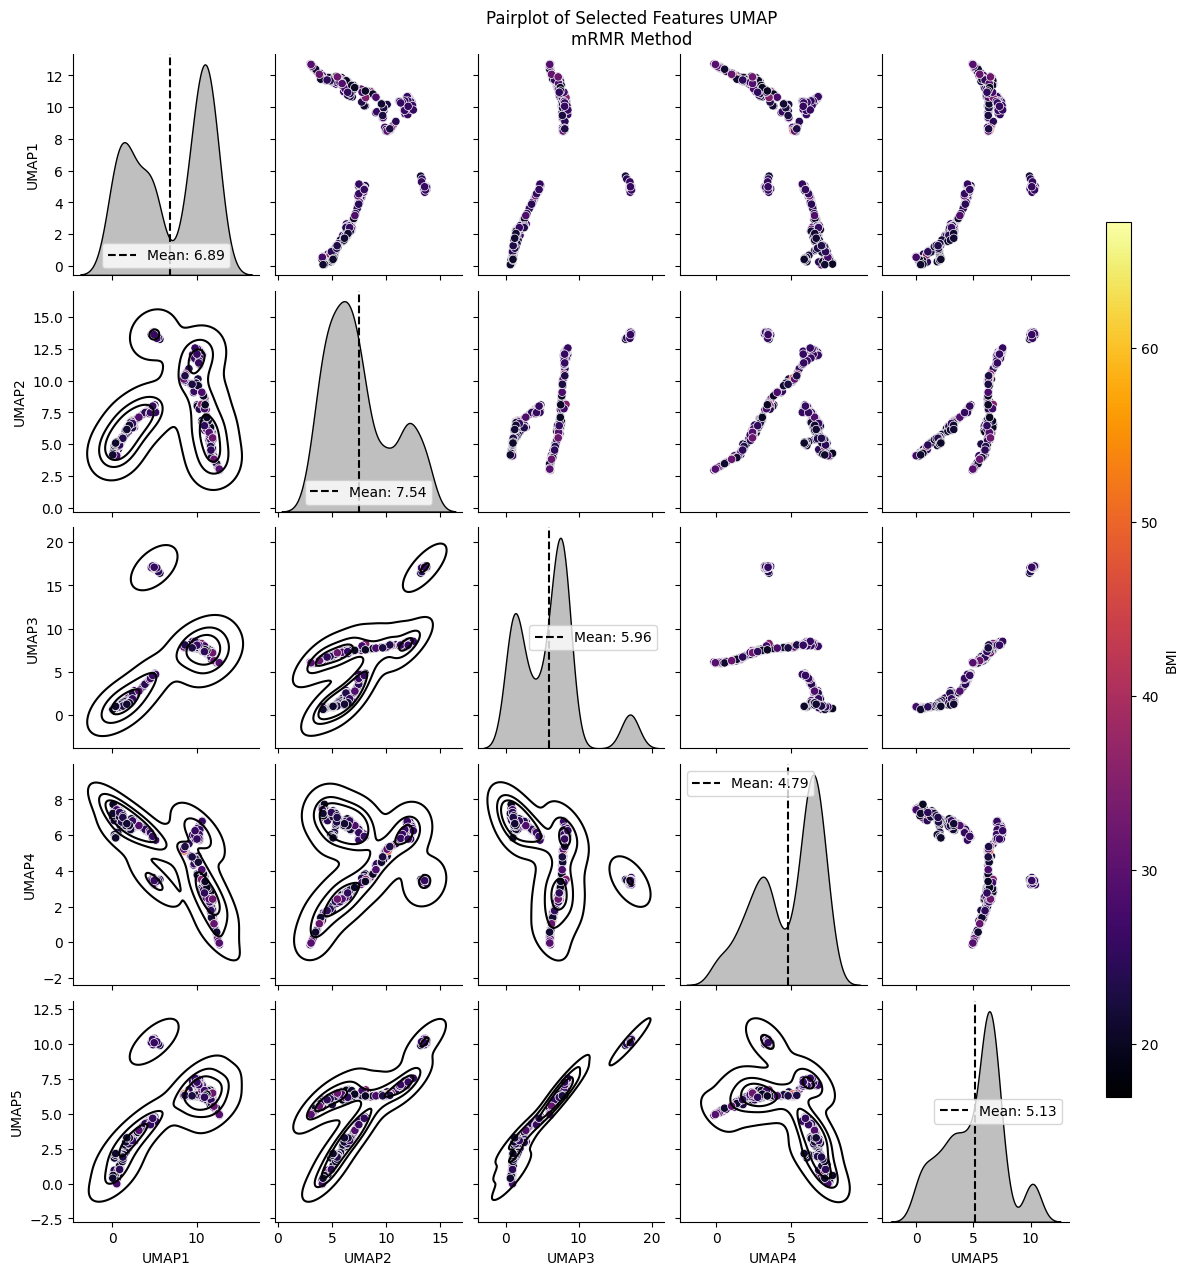

In [41]:
selected_features_umap = umap_model.fit_transform(selected_features_mrmr)

plot_correlated_pairplot(
    pd.DataFrame(
        selected_features_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Selected Features UMAP\nmRMR Method",
    kde_color="black",
    hue=bmi,
    cmap="inferno",
    overlay_correlations=False
)

### 4th method: Select features uwing a custom method

First, select the top $K$ bacteria that have `BMI` that deviates from the mean `BMI` the most when they are non-zero.

In [42]:
K = 10

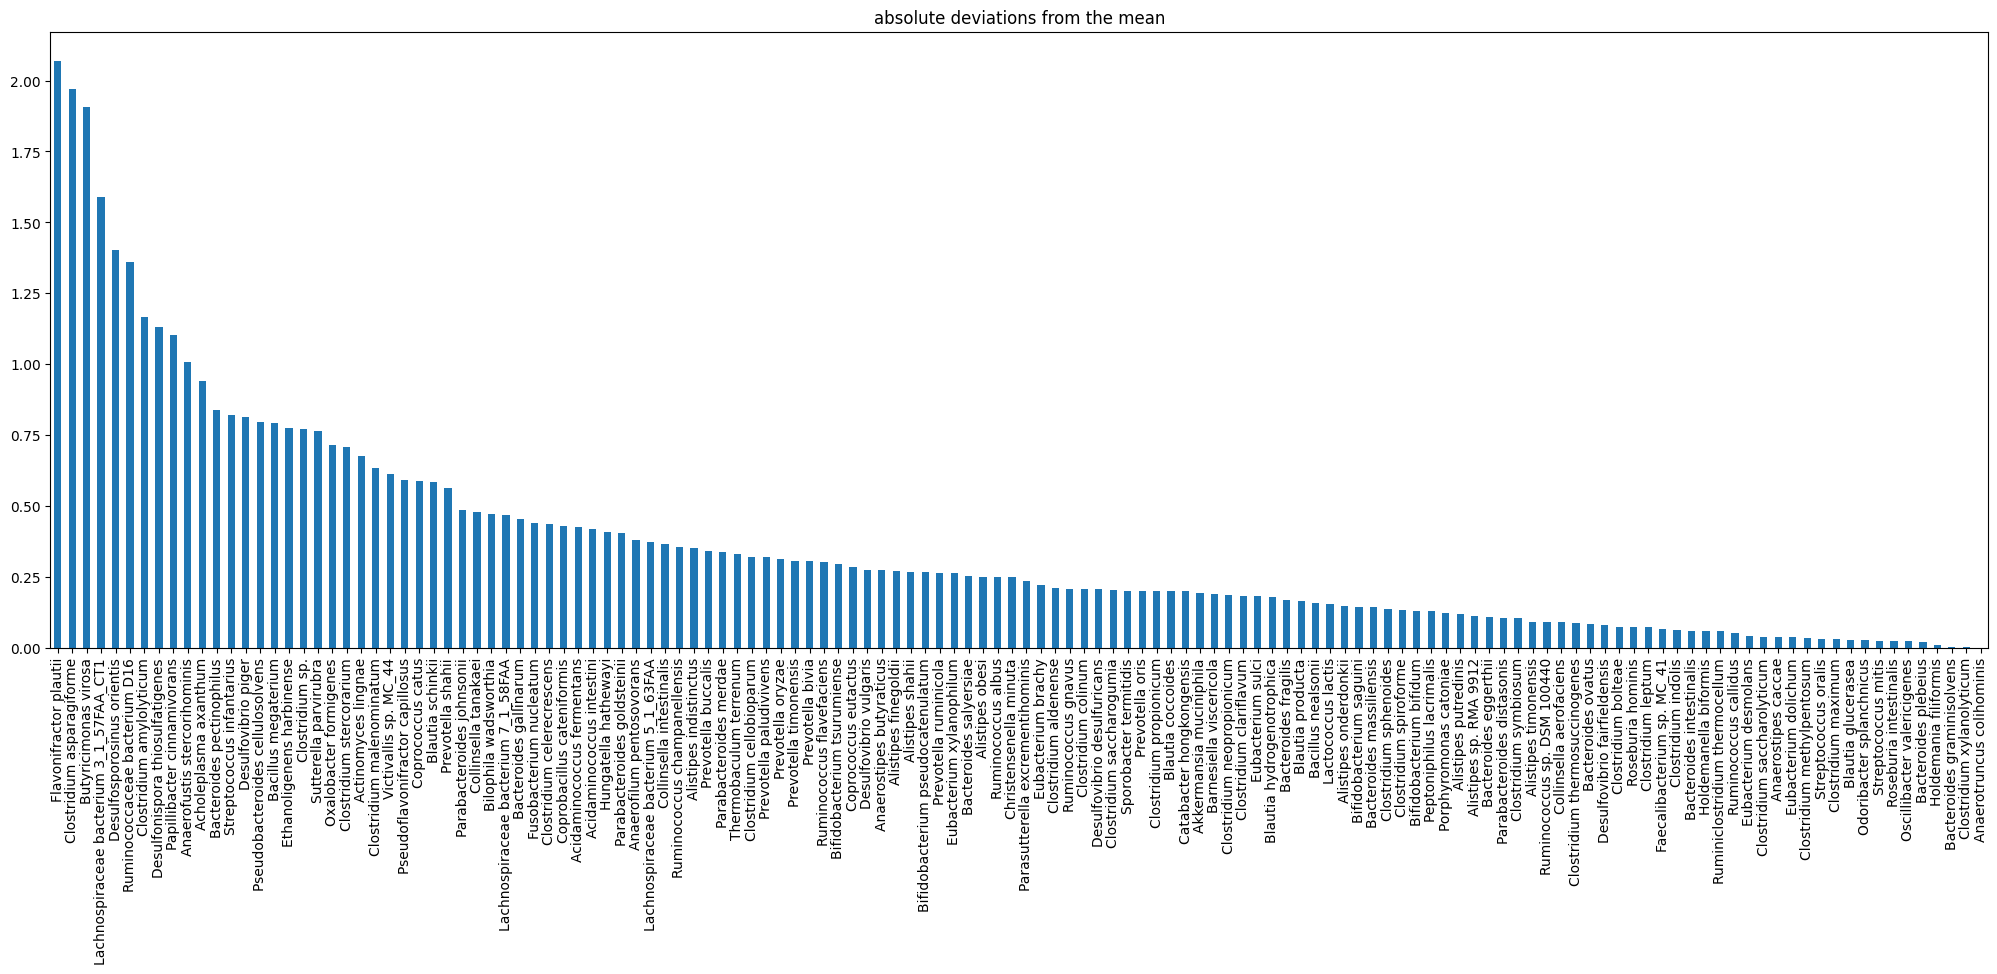

In [43]:
mean_BMI = bmi.mean()

zeros = bacteria.isin([0]).sum()

means = []
for col in zeros.index:
    non_zero_indices = bacteria[col] != 0
    mean_target = bmi[non_zero_indices].mean()
    means.append(mean_target)

means = np.array(means)

deviations = {}
for bac, mean in zip(zeros.index, means):
    deviations[bac] = abs(mean - mean_BMI)

deviations = pd.Series(deviations)
deviations = deviations.sort_values(ascending=False)

deviations.plot(
    kind="bar",
    figsize=(25, 8),
    title="absolute deviations from the mean"
)
plt.show()

In [44]:
top_K_bacteria = list(deviations.index[:K])
top_K_bacteria

['Flavonifractor plautii',
 'Clostridium asparagiforme',
 'Butyricimonas virosa',
 'Lachnospiraceae bacterium 3_1_57FAA_CT1',
 'Desulfosporosinus orientis',
 'Ruminococcaceae bacterium D16',
 'Clostridium amylolyticum',
 'Desulfonispora thiosulfatigenes',
 'Papillibacter cinnamivorans',
 'Anaerofustis stercorihominis']

Then select the top $L$ bacteria that are most correlated with `BMI`.

In [45]:
L = 10

In [46]:
bacteria_sorted_by_corr_bmi_not_in_top_K = [
    bac for bac in bacteria_sorted_by_corr_bmi if bac not in top_K_bacteria
]
top_L_bacteria = bacteria_sorted_by_corr_bmi_not_in_top_K[:L]
top_L_bacteria

['Alistipes putredinis',
 'Ruminococcus champanellensis',
 'Sporobacter termitidis',
 'Parabacteroides johnsonii',
 'Christensenella minuta',
 'Ruminococcus flavefaciens',
 'Eubacterium sulci',
 'Barnesiella viscericola',
 'Ruminiclostridium thermocellum',
 'Clostridium stercorarium']

Then select the top $M$ bacteria based on Lasso regression

In [47]:
M = 10

In [48]:
bacteria_standardized_not_in_top_L = bacteria_standardized.drop(
    top_L_bacteria, axis=1
)

lasso = LassoCV(cv=5, alphas=np.logspace(-3, 1, 50), random_state=42)
lasso.fit(bacteria_standardized_not_in_top_L, bmi)

if lasso.coef_.sum() == 0:
    print("All coefficients are zero")
else:
    print("Not all coefficients are zero")

Not all coefficients are zero


Since there are no non-zero coefficients, we continue with the next method, mRMR. We chose the top $R$ bacteria based on mRMR.

In [49]:
R = 10

In [50]:
top_R_bacteria = mrmr.mrmr_regression(
    bacteria_standardized_not_in_top_L,
    bmi,
    K=R
)
top_R_bacteria

100%|██████████| 10/10 [00:00<00:00, 49.45it/s]


['Desulfonispora thiosulfatigenes',
 'Pseudoflavonifractor capillosus',
 'Desulfovibrio desulfuricans',
 'Clostridium sp.',
 'Anaerotruncus colihominis',
 'Eubacterium dolichum',
 'Clostridium propionicum',
 'Bifidobacterium saguini',
 'Lachnospiraceae bacterium 7_1_58FAA',
 'Acholeplasma axanthum']

The final features are the combination of the top K, top L and top R features based on the above selections, along with age and sex.

In [51]:
selected_features_custom = pd.concat(
    [
        bacteria[top_K_bacteria],
        bacteria[top_L_bacteria],
        bacteria[top_R_bacteria],
        age,
        sex.replace({
        "Male": 1,
        "Female": -1
        })
    ],
    axis=1
)

In [52]:
selector = VarianceThreshold(threshold=0.1)
selector.fit(selected_features_custom)

new_row = pd.DataFrame({
    "Method": ["Custom"],
    "Number of Features": [selected_features_custom.shape[1]],
    "Mutual Information": [mutual_info_regression(
        selected_features_custom,
        bmi
    ).mean()],
    "Variance": [selected_features_custom[
        selected_features_custom.columns[selector.get_support()]
    ].var().mean()],
    "Information Gain": [mutual_info_regression(
        selected_features_custom,
        bmi
    ).mean()]
})

feature_selection_metrics = pd.concat(
    [
        feature_selection_metrics,
        new_row
    ],
    ignore_index=True
)

feature_selection_metrics

Method  Number of Features  Mutual Information    Variance  \
0  Correlation                35.0            0.123062   15.156343   
1        Lasso                 2.0            0.484809  124.161939   
2         mRMR                35.0            0.122174   19.273012   
3       Custom                32.0            0.108938   26.385323   

   Information Gain  
0          0.121079  
1          0.480316  
2          0.122049  
3          0.114216

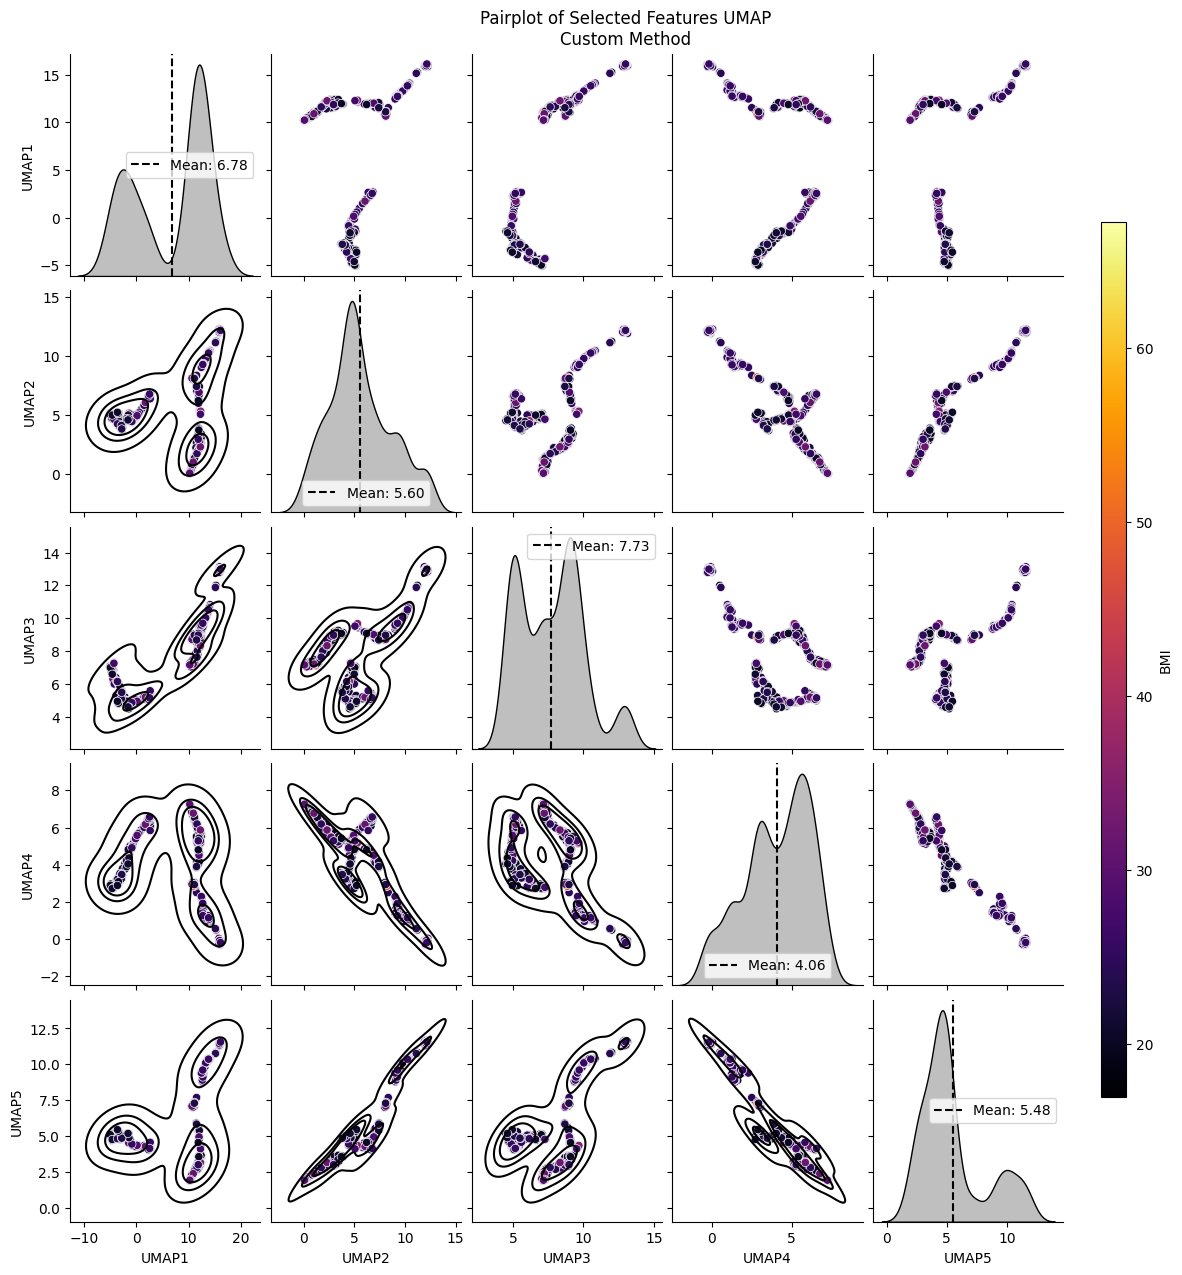

In [53]:
selected_features_umap = umap_model.fit_transform(selected_features_custom)

plot_correlated_pairplot(
    pd.DataFrame(
        selected_features_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Selected Features UMAP\nCustom Method",
    kde_color="black",
    hue=bmi,
    cmap="inferno",
    overlay_correlations=False
)

#### Plot of the metrics for all the feature selection methods

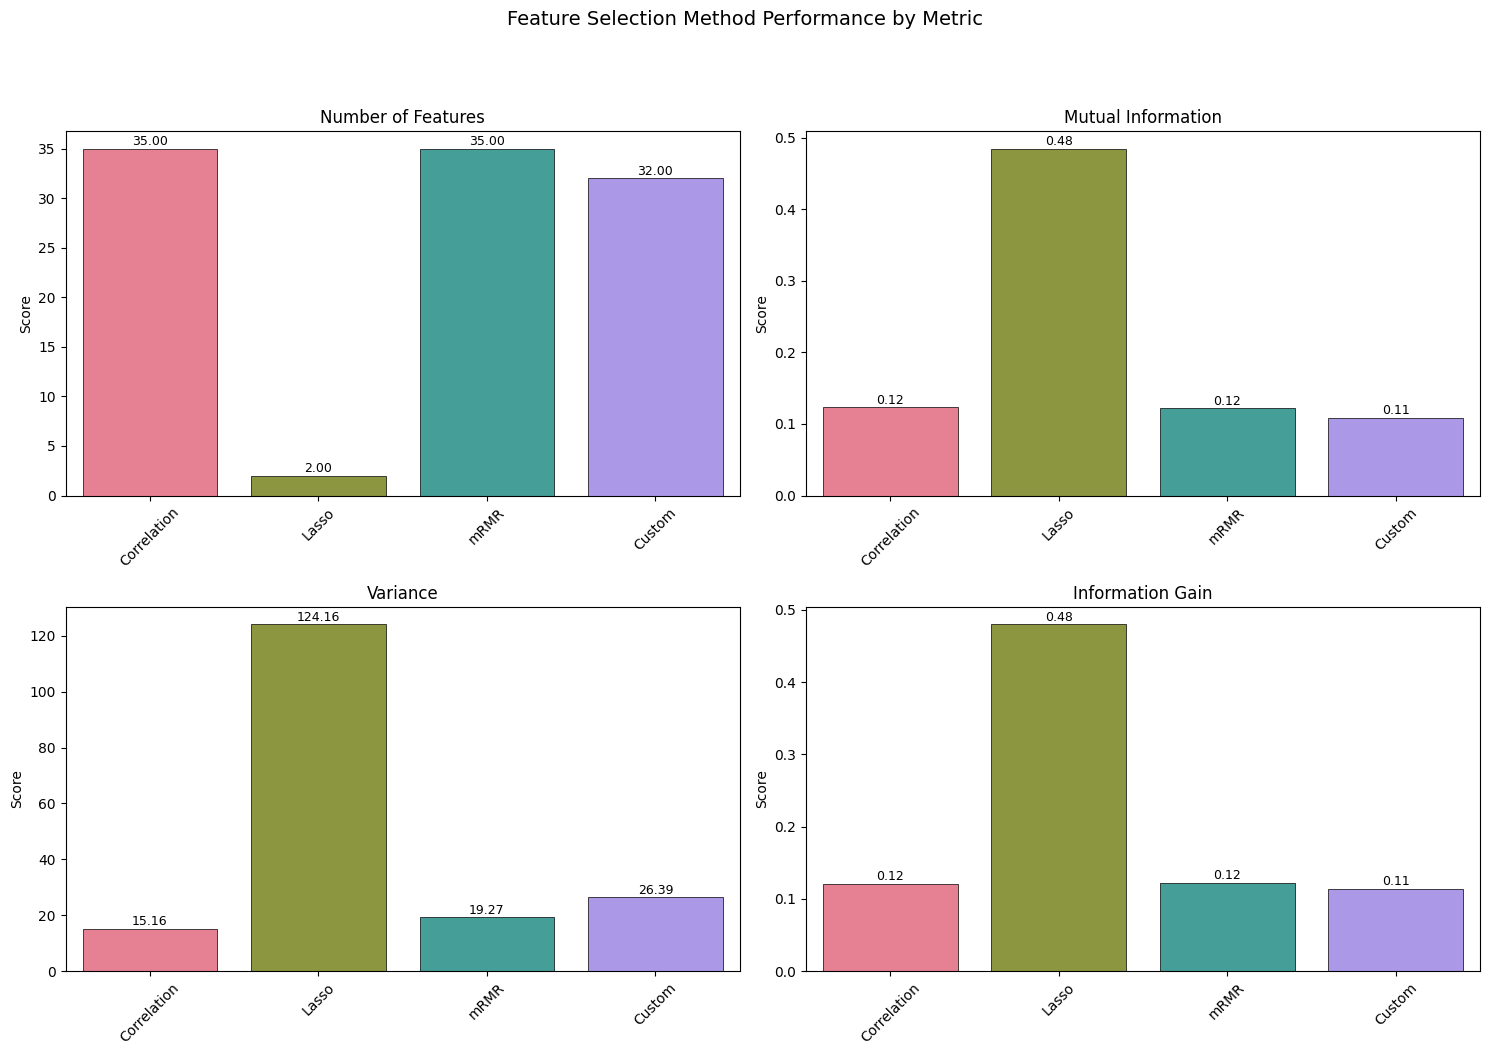

In [54]:
plot_feature_selection_metrics(feature_selection_metrics, (2, 2))

# Final Selection

The method that yields the best results is the one using correlation coefficients. It has the least variance, the most Mutual Information and Information Gain,
and it uses a small amount of features; when not considering Lasso, which ends up with only two features.

In [55]:
best_features = list(selected_features_corr.columns)
with open(os.path.join(BASE_DIR, "best_features.txt"), "w") as f:
    f.write("\n".join(best_features))